# HW 4 : Clustering 

In this HW we will use K-means variants on Fisher's Iris dataset

In [1]:
# relevant packges
%matplotlib inline
from sklearn import datasets, cluster, neighbors
import numpy as np
from numpy.linalg import norm
import copy
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# load data
iris = datasets.load_iris()

X_iris = iris.data
y_iris = iris.target    

In [3]:
# Check data type and dim
print (str(type(X_iris)) + 'dimensions: '+str(X_iris.shape))
print (str(type(y_iris)) + 'dimensions: '+str(y_iris.shape))
print (X_iris[1,:])

<type 'numpy.ndarray'>dimensions: (150L, 4L)
<type 'numpy.ndarray'>dimensions: (150L,)
[ 4.9  3.   1.4  0.2]


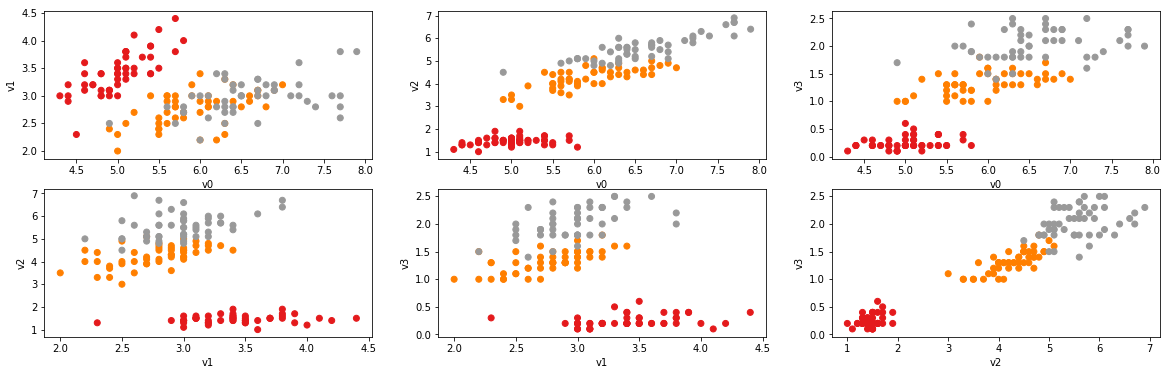

In [4]:
# Visualize 2d projections
fig = plt.figure(1, figsize=(20, 6))
itr = 1
for i in xrange(0,4):
    for j in xrange(i+1,4):
        plt.subplot(2,3,itr)
        plt.scatter(X_iris[:,i], X_iris[:,j], c=y_iris, cmap=plt.cm.Set1)
        plt.xlabel('v'+str(i))
        plt.ylabel('v'+str(j))
        itr+=1

[]

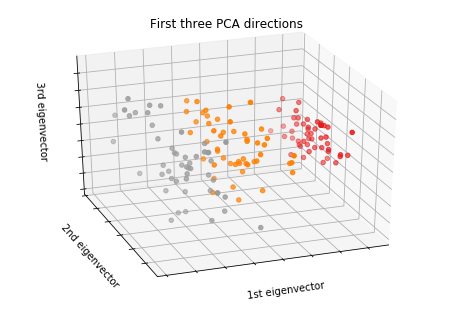

In [5]:
# Question 1 - fill in the code as required
fig = plt.figure(2)
X_reduced = np.zeros((y_iris.size,3))
#  Obtain first 3 PCA directions by using PCA method fit_transform 
######## Your Code Here ##########

X_reduced = PCA(n_components=3).fit_transform(X_iris)

##################################
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_iris,
           cmap=plt.cm.Set1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

In [6]:
# Question 2 - fill in the code as required

######## Your Code Here ##########
# Cluster via KMeans from cluster
# tweak parameters/ use a grid search for best results

k_means = cluster.KMeans(n_clusters=len(set(y_iris)))

# We're tweaking parameters based on the documentaion found here:
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

##################################
# cluster
k_means.fit(X_iris) 
# obtain labels
sk_k_means_labels = k_means.labels_

In [7]:
# Question 3 - write a function that computes the number of correct labels
def correctLabelNum(y_iris,labels):
    
    # We built this function in a way that enables it to also handle outliers, 
    # in order to use it also for the DBSCAN algorithm:
    
    # first seperated the outliers from the rest of the labels:
    outliers = np.array(np.where(labels < 0)).T
    labels = labels[labels >=0]
    num_labels = len(np.unique(labels))
    num_of_real_labels = len(np.unique(y_iris))
    
    matching_labels_arr = np.zeros((len(labels) + len(outliers)))
    
    # for each aribitrary label, find the "right label" for it,
    # which will match the labels in y_iris (which means that most of 
    # the arbitrary label's data points really belong to that specific label in y_iris):
    for label in range(num_labels):
                  
        algo_indices = np.array(np.where(labels == label)).T
        sum_indices_per_real_label = np.zeros(num_of_real_labels)
        for i,idx in enumerate(algo_indices):
            sum_indices_per_real_label[y_iris[idx]] += 1

        right_label = np.argmax(sum_indices_per_real_label)
        
        for idx in algo_indices:
            matching_labels_arr[idx] = right_label
    
    # add the outliers:
    for idx in outliers:
        matching_labels_arr[idx] = -1 
    
    # return the number of correctly labeled points:
    return sum(y_iris == matching_labels_arr)

In [8]:
# check precentage of correct classification

print "sklearn K-means classified " + str(correctLabelNum(y_iris,sk_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"

sklearn K-means classified 134:150 correctly


In [9]:
# Justified the parameters selection:

def testKMeans(k_means):
   
    # cluster
    k_means.fit(X_iris) 
    # obtain labels
    sk_k_means_labels = k_means.labels_
    print "sklearn K-means classified " + str(correctLabelNum(y_iris,sk_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"
    
    
kMeansList = [
    cluster.KMeans(n_clusters=len(set(y_iris))),
    cluster.KMeans(n_clusters=len(set(y_iris)), n_init=20),
    cluster.KMeans(n_clusters=len(set(y_iris)), n_init=30),
    cluster.KMeans(n_clusters=len(set(y_iris)), n_init=40),
    cluster.KMeans(n_clusters=len(set(y_iris)), max_iter=600),
    cluster.KMeans(n_clusters=len(set(y_iris)), max_iter=1200),
    cluster.KMeans(n_clusters=len(set(y_iris)), init='random'),
    cluster.KMeans(n_clusters=len(set(y_iris)), tol=1e-12, max_iter=1200)   
]

for i,k in enumerate(kMeansList):
    print 'checking ',i,'res is:'
    testKMeans(k)

checking  0 res is:
sklearn K-means classified 134:150 correctly
checking  1 res is:
sklearn K-means classified 134:150 correctly
checking  2 res is:
sklearn K-means classified 134:150 correctly
checking  3 res is:
sklearn K-means classified 134:150 correctly
checking  4 res is:
sklearn K-means classified 134:150 correctly
checking  5 res is:
sklearn K-means classified 134:150 correctly
checking  6 res is:
sklearn K-means classified 134:150 correctly
checking  7 res is:
sklearn K-means classified 134:150 correctly


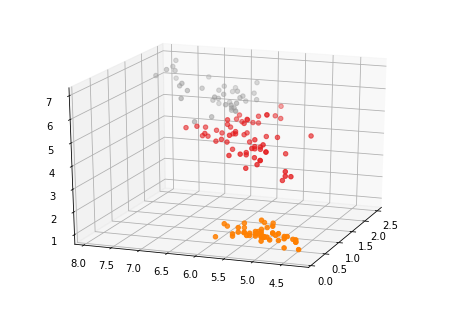

In [10]:
# Visualize clustering by sklearn K-means
fig = plt.figure(3)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=sk_k_means_labels,
           cmap=plt.cm.Set1)

In [40]:
# Utility functions for the clustering algorithms' implementation:
def pick_random_centers(num_centers, X):
    random_init = np.random.choice(range(len(X)), num_centers)
    R = X[random_init,:]
    return R

def calculate_distances_mat(centers, X):
    distances_mat = np.zeros((X.shape[0], centers.shape[0]))
    for i,xi in enumerate(X):
        for j,yj in enumerate(centers):
            distances_mat[i][j] = np.square(norm(xi-yj))
    return distances_mat

def calculate_P_mat(distances_mat):
    num_data = distances_mat.shape[0]
    num_centers = distances_mat.shape[1]
    
    P_mat = np.zeros((num_data, num_centers))
    for i in range(num_data):
        i_min = min(distances_mat[i,:])
        for j in range(num_centers):
            if(distances_mat[i][j] == i_min):
                P_mat[i][j] = 1
            else:
                P_mat[i][j] = 0
    return P_mat

def calculate_soft_P_mat(distances_mat, beta):
    num_data = distances_mat.shape[0]
    num_centers = distances_mat.shape[1]
    
    P_mat = np.zeros((num_data, num_centers))
    
    for i in range(num_data):
        Z = 0
        for j in range(num_centers):
            Z += math.exp((-beta)*distances_mat[i][j])
            
        for j in range(num_centers):
            P_mat[i][j] = (math.exp((-beta)*distances_mat[i][j]) / float(Z))
    return P_mat

def calculate_centers(P_mat, X):

    num_centers = P_mat.shape[1]
    R = np.zeros((num_centers, X.shape[1]))

    for j in range(num_centers):
        x_sum = 0;
        total_sum = 0;
        for i,xi in enumerate(X):
            x_sum += P_mat[i][j] * xi
            total_sum += P_mat[i][j]
        R[j] = (x_sum / float(total_sum))
    return R

def calculate_medoids(P_mat, X):

    num_medoids = P_mat.shape[1]
    R = np.zeros((num_medoids, X.shape[1]))

    for j in range(num_medoids):
        clusterElems = []
        for i,xi in enumerate(X):
            if P_mat[i][j] == 1:
                clusterElems.append(xi)
        clusterElems = [xi for i,xi in enumerate(X) if P_mat[i][j]==1]
        sumsArr = np.zeros(len(clusterElems))
        
        for cIdx,cElem in enumerate(clusterElems):
            distancesToElem = np.asarray([(cElem-c)**2 for c in clusterElems])
            sumsArr[cIdx] = np.sum(distancesToElem)
        
 
        R[j] = clusterElems[np.argmin(sumsArr)]

        
#         x_sum = 0;
#         total_sum = 0;
#         for i,xi in enumerate(X):
#             x_sum += P_mat[i][j] * xi
#             total_sum += P_mat[i][j]
#         R[j] = (x_sum / float(total_sum))
    return R


def calculate_old_and_new_distances(X, R, P_mat, distances_mat):
    R_updated_distances = 0
    R_distances = 0
    for i,xi in enumerate(X):
        for j,yj in enumerate(R):
            R_updated_distances += P_mat[i][j] * distances_mat[i][j]
            R_distances += P_mat[i][j] * np.square(norm(xi-yj)) 
    return R_updated_distances, R_distances

In [12]:
# Question 4 - Implement K-means by yourself (don't use any k-mean libarary code )
#              your implementation outputs should be consisted with sklearn K-means
class K_means_vanilla:
    def __init__(self,n_clusters=1):
        self.n_clusters = n_clusters
        ######## Your Code Here ##########
        self.epsilon = 1e-4
        self.max_iterations = 300;
        self.R = np.zeros(self.n_clusters)        
        
        ##################################
        
    def fit(self,X):
        ######## Your Code Here ##########
        
        # Try 10 times to run the k-means algorithm, each time with random initial centers,
        # and return the best result:
        
        # create variables and matrixes for later use:
        num_data = X.shape[0]
        num_centers = self.n_clusters
        distances_mat = np.zeros((num_data, num_centers))
        self.P_mat = np.zeros((num_data, num_centers))
        
        best_R_distances = -1 ;
        self.P_mat_best = np.zeros((num_data, num_centers))
        
        for i in range(10):
        
            # init random centers, by choosing random X vectors:
            self.R = copy.deepcopy(pick_random_centers(self.n_clusters, X))

            # iterate to find the best centers:
            for i in range(self.max_iterations):
                self.R_updated = copy.deepcopy(self.R[:,:])

                # calculate the matrix P:
                distances_mat = copy.deepcopy(calculate_distances_mat(self.R_updated, X))
                
                self.P_mat = copy.deepcopy(calculate_P_mat(distances_mat))

                # calculate the new centers:
                self.R = copy.deepcopy(calculate_centers(self.P_mat, X))
                
                # calculate improvement:
                R_updated_distances, R_distances = calculate_old_and_new_distances(X, self.R, self.P_mat, distances_mat)

                # if the improvement is smaller then epsilon, stop iterating:               
                if (R_updated_distances - R_distances < self.epsilon):
                    break;
            if ((R_distances < best_R_distances) | (best_R_distances == -1)):
                best_R_distances = R_distances
                self.P_mat_best = copy.deepcopy(self.P_mat[:,:])
            
        return self.R          

        ##################################
        
        
    def labels(self):
        ######## Your Code Here ##########
        num_data = self.P_mat_best.shape[0]
        self.labels = np.zeros((num_data))
        for i in range(num_data):
            for j,yj in enumerate(self.P_mat_best[i,:]):
                if yj == 1:
                    self.labels[i] = j
        
        return self.labels.astype(int)        

        ##################################

Vanilla K-means classified 134:150 correctly


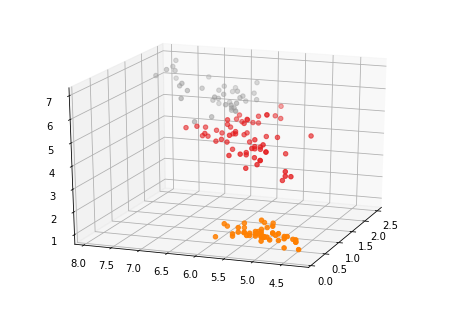

In [13]:
# Run vanilla K-means on data 
my_K_means_vanilla = K_means_vanilla(n_clusters = 3)
my_K_means_vanilla.fit(X_iris)
vanill_my_k_means_labels = my_K_means_vanilla.labels()

# Visualize vanilla K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=vanill_my_k_means_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "Vanilla K-means classified " + str(correctLabelNum(y_iris,vanill_my_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"

In [19]:
# Question 5 - Implement K-Medoids (don't use any k-mean libarary code)

class K_Medoids:
    def __init__(self,n_clusters=1):
        self.n_clusters = n_clusters
        ######## Your Code Here ##########
        self.epsilon = 1e-4
        self.max_iterations = 300;
        self.R = np.zeros(self.n_clusters)        
        
        ##################################
        
    def fit(self,X):
        ######## Your Code Here ##########
        
        # Try 10 times to run the k-means algorithm, each time with random initial centers,
        # and return the best result:
        
        # create variables and matrixes for later use:
        num_data = X.shape[0]
        num_centers = self.n_clusters
        distances_mat = np.zeros((num_data, num_centers))
        self.P_mat = np.zeros((num_data, num_centers))
        
        best_R_distances = -1 ;
        self.P_mat_best = np.zeros((num_data, num_centers))
        
        for i in range(10):
        
            # init random centers, by choosing random X vectors:
            self.R = copy.deepcopy(pick_random_centers(self.n_clusters, X))

            # iterate to find the best centers:
            for i in range(self.max_iterations):
                self.R_updated = copy.deepcopy(self.R[:,:])

                # calculate the matrix P:
                distances_mat = copy.deepcopy(calculate_distances_mat(self.R_updated, X))
                
                self.P_mat = copy.deepcopy(calculate_P_mat(distances_mat))

                # calculate the new centers:
#                 self.R = copy.deepcopy(calculate_centers(self.P_mat, X))
                self.R = copy.deepcopy(calculate_medoids(self.P_mat,X))
                # calculate improvement:
                R_updated_distances, R_distances = calculate_old_and_new_distances(X, self.R, self.P_mat, distances_mat)

                # if the improvement is smaller then epsilon, stop iterating:               
                if (R_updated_distances - R_distances < self.epsilon):
                    break;
                    
            if ((R_distances < best_R_distances) | (best_R_distances == -1)):
                best_R_distances = R_distances
                self.P_mat_best = copy.deepcopy(self.P_mat[:,:])
            
        return self.R          

        ##################################
        
        
    def labels(self):
        ######## Your Code Here ##########
        num_data = self.P_mat_best.shape[0]
        self.labels = np.zeros((num_data))
        for i in range(num_data):
            for j,yj in enumerate(self.P_mat_best[i,:]):
                if yj == 1:
                    self.labels[i] = j
        
        return self.labels.astype(int)        

        ##################################


K-Medoids classified 135:150 correctly


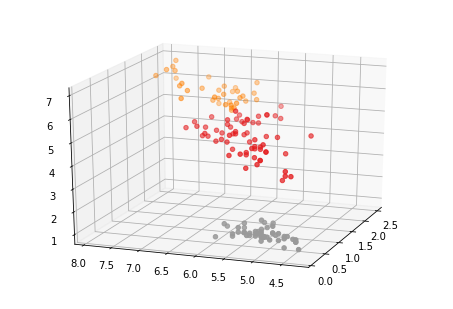

In [42]:
# Run K-Medoids on data 
my_K_Medoids = K_Medoids(n_clusters = 3)
my_K_Medoids.fit(X_iris)
my_K_Medoids_labels = my_K_Medoids.labels()

# Visualize vanilla K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=my_K_Medoids_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "K-Medoids classified " + str(correctLabelNum(y_iris,my_K_Medoids_labels))+ ":"+ str(y_iris.size)+ " correctly"

In [ ]:
# Question 6 - Implement soft K-Means (don't use any k-mean libarary code)
class soft_K_Means:
    def __init__(self,n_clusters=1):
        self.n_clusters = n_clusters
        ######## Your Code Here ##########
        self.epsilon = 1e-4
        self.max_iterations = 300;
        self.beta = 0.6  # tradeoff between belonging to the closest center, and belonging to ,multiple centers
        self.R = np.zeros(self.n_clusters)

        ##################################
        
    def fit(self,X):
        ######## Your Code Here ##########
        
        # Try 10 times to run the soft-k-means algorithm, each time with random initial centers,
        # and return the best result:
        
        # create variables and matrixes for later use:
        num_data = X.shape[0]
        num_centers = self.n_clusters
        distances_mat = np.zeros((num_data, num_centers))
        self.P_mat = np.zeros((num_data, num_centers))
        
        best_R_distances = -1 ;
        self.P_mat_best = np.zeros((num_data, num_centers))
        
        for i in range(10):
        
            # init random centers, by choosing random X vectors:
            self.R = copy.deepcopy(pick_random_centers(self.n_clusters, X))

            # iterate to find the best centers:
            for i in range(self.max_iterations):
                self.R_updated = copy.deepcopy(self.R[:,:])

                # calculate the soft matrix P:
                distances_mat = copy.deepcopy(calculate_distances_mat(self.R_updated, X))
                
                self.P_mat = copy.deepcopy(calculate_soft_P_mat(distances_mat, self.beta))

                # calculate the new centers:
                self.R = copy.deepcopy(calculate_centers(self.P_mat, X))
                
                # calculate improvement:
                R_updated_distances, R_distances = calculate_old_and_new_distances(X, self.R, self.P_mat, distances_mat)

                # if the improvement is smaller then epsilon, stop iterating:               
                if (R_updated_distances - R_distances < self.epsilon):
                    break;
            if ((R_distances < best_R_distances) | (best_R_distances == -1)):
                best_R_distances = R_distances
                self.P_mat_best = copy.deepcopy(self.P_mat[:,:])
            
        return self.R 

        ##################################
        
    def labels(self):
        ######## Your Code Here ##########
        num_data = self.P_mat_best.shape[0]
        self.labels = np.zeros((num_data))
        for i in range(num_data):
            self.labels[i] = np.argmax(np.array(self.P_mat_best[i,:]))
        
        return self.labels.astype(int)

        ##################################

In [ ]:
# Run soft K-Means on data 
my_soft_K_Means = soft_K_Means(n_clusters = 3)
my_soft_K_Means.fit(X_iris)
my_soft_K_Means_labels = my_soft_K_Means.labels()

# Visualize soft K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=my_soft_K_Means_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "soft K-means classified " + str(correctLabelNum(y_iris,my_soft_K_Means_labels))+ ":"+ str(y_iris.size)+ " correctly"

In [ ]:
# Wet assignment - Part 2:
# Use sklearn's dbscan clustering implementation, and compare the results
# with your k-means implementation:

# first, we'll choose the parameters (min_samples, eps) for the DBSCAN algorithm:

# As a rule of thumb, a minimum 'min_samples' can be derived from the number of dimensions D in the data set:
min_samples = X_iris.shape[1]

# We'll find the suitable eps, with a KNN graph:
nbrs = neighbors.NearestNeighbors(n_neighbors=min_samples).fit(X_iris)
distances, indices = nbrs.kneighbors(X_iris)
fig = plt.figure(5)
plt.plot(np.sort(distances[:,3])[::-1])

# one can notice that there is a bend in the 0.4 distance, meaning that choosing a distance bigger than 0.4, will 
# increase the number of "core-points" in the DBSCAN slowly, and choosing a smaller distance will result in a much 
# lower number of "core-points". For that reason, we will choose 0.4 distance.

sklearn_DBSCAN = cluster.DBSCAN(eps=0.4, min_samples=4)
sklearn_DBSCAN.fit(X_iris)
sklearn_DBSCAN_labels = sklearn_DBSCAN.labels_

# Visualize soft K means clustering
fig = plt.figure(6)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=sklearn_DBSCAN_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "DBSCAN classified " + str(correctLabelNum(y_iris,sklearn_DBSCAN_labels))+ ":"+ str(y_iris.size)+ " correctly"


According to the results stated above, we can see that in this particular case, the k-means algorithm we implemented worked better than the DBSCAN algorithm (134 vs 93 correctly labeled data points). 

However, we should mention that this case doesn't use the DBSCAN's algorithm main advantages:
1) DBSCAN does not require one to specify the number of clusters in the data a priori, as opposed to k-means. However, in this case, the number of clusters was already known.
2) DBSCAN can find arbitrarily shaped clusters. However, in this case, the clusters are "regular" clouds of data (and not, for instance, a circle within a circle).

In addition, the DBSCAN algorithm finds outliers in the data. However, in this case, we a priopri know that there shouldn't be any outliers.